
# COMM7370 AI Theories and Applications

# Predicting House Prices on Kaggle


Let's put all this knowledge into practice
by participating in a Kaggle competition.
[Predicting house prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) is a great place to start:
- the data is reasonably generic and does not have
- the kind of rigid structure that might require specialized models the way images or audio might.
This dataset, consists in examples and features 
covering house prices in Ames, IA from the period of 2006-2010.

In this section, we will go through details of data preprocessing,
model design, hyperparameter selection and tuning.

We hope that through a hands-on approach,
you will be able to observe the effects of capacity control,
feature extraction, etc. in practice.

This experience is vital to gaining intuition as a data scientist.

## Downloading and Caching Datasets

Throughout the course we will train and test models on various downloaded datasets. Here we implement several utility functions to facilitate data downloading. First, we maintain a dictionary `DATA_HUB` that maps a string name to a URL with the SHA-1 of the file to verify the integrity of the file. Such datasets are hosted on the `DATA_URL` site.

The following `download` function downloads the dataset from 
the URL mapping the specified dataset `name` to a local cache directory (`../data` by default).
If the file already exists in the cache directory and its SHA-1 matches the one stored in `DATA_HUB`, the cached file will be used and no downloading is needed.
That is to say, you only need to download datasets once with a network connection.
This `download` function returns the name of the downloaded file.

We also implement two additional functions: one is to download and extract a zip/tar file, and the other to download all the files from `DATA_HUB` into the cache directory. You may invoke the latter to download all these datasets once and for all if your network connection is slow.

## Kaggle

[Kaggle](https://www.kaggle.com) is a popular platform
for machine learning competitions.
It combines data, code and users in a way to allow
for both collaboration and competition.
While leaderboard chasing can sometimes get out of control,
there is also a lot to be said for the objectivity in a platform
that provides fair and direct quantitative comparisons
between your approaches and those devised by your competitors.
Moreover, you can checkout the code
from (some) other competitors' submissions
and pick apart their methods to learn new techniques.
If you want to participate in one of the competitions,
you need to register for an account as shown in 
figure.

![Kaggle website](../img/kaggle.png)



On the House Prices Prediction page as illustrated 
in the following figure,
you can find the dataset (under the "Data" tab),
submit predictions, see your ranking, etc.,
The URL is right here:

> https://www.kaggle.com/c/house-prices-advanced-regression-techniques

![House Price Prediction](../img/house_pricing.png)

## Accessing and Reading the Dataset

Note that the competition data is separated into training and test sets.
Each record includes the property value of the house
and attributes such as street type, year of construction,
roof type, basement condition, etc.
The features represent multiple data types.
Year of construction, for example, is represented with integers
roof type is a discrete categorical feature,
other features are represented with floating point numbers.
And here is where reality comes in:
for some examples, some data is altogether missing
with the missing value marked simply as 'na'.
The price of each house is included for the training set only
(it is a competition after all).
You can partition the training set to create a validation set,
but you will only find out how you perform on the official test set
when you upload your predictions and receive your score.
The "Data" tab on the competition tab has links to download the data.


We will read and process the data using `pandas` (as always).

In [1]:
%matplotlib inline
import d2l
from mxnet import autograd, init, np, npx
from mxnet.gluon import nn
import pandas as pd
npx.set_np()
import os
from mxnet import gluon
import random

In [2]:
dataset=pd.read_csv('train_sales_data.csv')

In [3]:
dataset=dataset.drop('bodyType',axis=1)

In [4]:
dataset

,province,adcode,model,regYear,regMonth,salesVolume
0,上海,310000,3c974920a76ac9c1,2016,1,292
1,云南,530000,3c974920a76ac9c1,2016,1,466
2,内蒙古,150000,3c974920a76ac9c1,2016,1,257
3,北京,110000,3c974920a76ac9c1,2016,1,408
4,四川,510000,3c974920a76ac9c1,2016,1,610
...,...,...,...,...,...,...
43291,内蒙古,150000,32d3069d17aa47c2,2017,8,58
43292,内蒙古,150000,32d3069d17aa47c2,2017,9,74
43293,内蒙古,150000,32d3069d17aa47c2,2017,10,48
43294,内蒙古,150000,32d3069d17aa47c2,2017,11,48


In [5]:

    dataNumber = len(dataset) # 数据集数据条数
    index=list(int(i) for i in range(0,len(dataset)))
    testNumber = int(dataNumber * 0.2)
    datasetnumber=[]
    for i in index:
        datasetnumber.append(i)
    testDataSet = random.sample(datasetnumber, testNumber)
    province=[]
    adcode=[]
    model=[]
    regYear=[]
    regMonth=[]
    salesVolume=[]
    Citynumber=[]
    Modelnum=[]
    for i in testDataSet:
        adcode.append(dataset['adcode'][i])
        regYear.append(dataset['regYear'][i])
        regMonth.append(dataset['regMonth'][i])
        salesVolume.append(dataset['salesVolume'][i])
        province.append(dataset['province'][i])
        model.append(dataset['model'][i])
    testsetdf={'province':province,'adcode':adcode,'model':model,'regYear':regYear,'regMonth':regMonth,
               'salesVolume':salesVolume}
    test_data=pd.DataFrame.from_dict(testsetdf,orient='index').transpose()
    test_data['regMonth']=test_data['regMonth'].astype('int64')
    test_data['salesVolume']=test_data['salesVolume'].astype('int64')
    test_data['adcode']=test_data['adcode'].astype('int64')
    test_data['regYear']=test_data['regYear'].astype('int64')
    train_data=dataset.drop(testDataSet)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34637 entries, 0 to 43295
Data columns (total 6 columns):
province       34637 non-null object
adcode         34637 non-null int64
model          34637 non-null object
regYear        34637 non-null int64
regMonth       34637 non-null int64
salesVolume    34637 non-null int64
dtypes: int64(4), object(2)
memory usage: 1.8+ MB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8659 entries, 0 to 8658
Data columns (total 6 columns):
province       8659 non-null object
adcode         8659 non-null int64
model          8659 non-null object
regYear        8659 non-null int64
regMonth       8659 non-null int64
salesVolume    8659 non-null int64
dtypes: int64(4), object(2)
memory usage: 406.0+ KB


For convenience, we download and cache the Kaggle housing dataset from the `DATA_URL` website. For the other Kaggle competitions, you may need to download them manually.

To load the two csv files
containing training and test data respectively we use Pandas.

The training dataset includes $1,460$ examples, $80$ features, and $1$ label,
while the test data contains $1,459$ examples and $80$ features.

In [8]:
print(train_data.shape)
print(test_data.shape)

(34637, 6)
(8659, 6)


In [9]:
train_data

,province,adcode,model,regYear,regMonth,salesVolume
0,上海,310000,3c974920a76ac9c1,2016,1,292
1,云南,530000,3c974920a76ac9c1,2016,1,466
2,内蒙古,150000,3c974920a76ac9c1,2016,1,257
4,四川,510000,3c974920a76ac9c1,2016,1,610
5,安徽,340000,3c974920a76ac9c1,2016,1,206
...,...,...,...,...,...,...
43291,内蒙古,150000,32d3069d17aa47c2,2017,8,58
43292,内蒙古,150000,32d3069d17aa47c2,2017,9,74
43293,内蒙古,150000,32d3069d17aa47c2,2017,10,48
43294,内蒙古,150000,32d3069d17aa47c2,2017,11,48


In [10]:
test_data

,province,adcode,model,regYear,regMonth,salesVolume
0,河南,410000,8cbac8dd8f0e89e2,2016,3,229
1,陕西,610000,3c974920a76ac9c1,2016,1,298
2,广西,450000,f5d69960089c3614,2016,2,18
3,江苏,320000,b9aa8592ab2492da,2016,8,381
4,陕西,610000,97f15de12cfabbd5,2016,2,89
...,...,...,...,...,...,...
8654,江西,360000,ef76a85c4b39f693,2017,3,151
8655,四川,510000,c6833cb891626c17,2017,12,1008
8656,湖北,420000,9a390098bf87b814,2017,12,78
8657,云南,530000,8527c11fccaa94e2,2017,12,265


Let’s take a look at the first 4 and last 2 features
as well as the label (SalePrice) from the first 4 examples:

In [11]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

  province  adcode             model  regYear  regYear  regMonth  salesVolume
0       上海  310000  3c974920a76ac9c1     2016     2016         1          292
1       云南  530000  3c974920a76ac9c1     2016     2016         1          466
2      内蒙古  150000  3c974920a76ac9c1     2016     2016         1          257
4       四川  510000  3c974920a76ac9c1     2016     2016         1          610


We can see that in each example, the first feature is the ID.
This helps the model identify each training example.
While this is convenient, it does not carry
any information for prediction purposes.
Hence we remove it from the dataset before feeding the data into the network.

In [12]:
all_features = pd.concat((train_data.iloc[:, 0:5], test_data.iloc[:, 0:5]))

In [13]:
all_features

,province,adcode,model,regYear,regMonth
0,上海,310000,3c974920a76ac9c1,2016,1
1,云南,530000,3c974920a76ac9c1,2016,1
2,内蒙古,150000,3c974920a76ac9c1,2016,1
4,四川,510000,3c974920a76ac9c1,2016,1
5,安徽,340000,3c974920a76ac9c1,2016,1
...,...,...,...,...,...
8654,江西,360000,ef76a85c4b39f693,2017,3
8655,四川,510000,c6833cb891626c17,2017,12
8656,湖北,420000,9a390098bf87b814,2017,12
8657,云南,530000,8527c11fccaa94e2,2017,12


## Data Preprocessing

As stated above, we have a wide variety of data types.
Before we feed it into a deep network,
we need to perform some amount of processing.
Let's start with the numerical features.
We begin by replacing missing values with the mean.
This is a reasonable strategy if features are missing at random.
To adjust them to a common scale,
we rescale them to zero mean and unit variance.
This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}.$$

To check that this transforms $x$ to data
with zero mean and unit variance simply calculate
$E[(x-\mu)/\sigma] = (\mu - \mu)/\sigma = 0$.
To check the variance we use $E[(x-\mu)^2] = \sigma^2$
and thus the transformed variable has unit variance.
The reason for "normalizing" the data is that
it brings all features to the same order of magnitude.
After all, we do not know *a priori*
which features are likely to be relevant.

In [14]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing
# values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [15]:
all_features

,province,adcode,model,regYear,regMonth
0,上海,-0.276834,3c974920a76ac9c1,-0.999988,-1.593237
1,云南,1.337476,3c974920a76ac9c1,-0.999988,-1.593237
2,内蒙古,-1.450878,3c974920a76ac9c1,-0.999988,-1.593237
4,四川,1.190721,3c974920a76ac9c1,-0.999988,-1.593237
5,安徽,-0.056701,3c974920a76ac9c1,-0.999988,-1.593237
...,...,...,...,...,...
8654,江西,0.090055,ef76a85c4b39f693,0.999988,-1.013878
8655,四川,1.190721,c6833cb891626c17,0.999988,1.593237
8656,湖北,0.530321,9a390098bf87b814,0.999988,1.593237
8657,云南,1.337476,8527c11fccaa94e2,0.999988,1.593237


Next we deal with discrete values.
This includes variables such as 'MSZoning'.
We replace them by a one-hot encoding
in the same manner as how we transformed multiclass classification data
into a vector of $0$ and $1$.
For instance, 'MSZoning' assumes the values 'RL' and 'RM'.
They map into vectors $(1, 0)$ and $(0, 1)$ respectively.
Pandas does this automatically for us.

In [16]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and
# creates an indicative feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(43296, 109)

In [17]:
all_features

,adcode,regYear,regMonth,province_上海,province_云南,province_内蒙古,province_北京,province_四川,province_安徽,province_山东,...,model_ea489c253676aafc,model_ef76a85c4b39f693,model_f270f6a489c6a9d7,model_f5d69960089c3614,model_f8a6975573af1b33,model_fc32b1a017b34efe,model_fde95ea242abd896,model_feabbf46658382b9,model_ffeb3a4cec627e8c,model_nan
0,-0.276834,-0.999988,-1.593237,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.337476,-0.999988,-1.593237,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1.450878,-0.999988,-1.593237,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.190721,-0.999988,-1.593237,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,-0.056701,-0.999988,-1.593237,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8654,0.090055,0.999988,-1.013878,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8655,1.190721,0.999988,1.593237,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8656,0.530321,0.999988,1.593237,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8657,1.337476,0.999988,1.593237,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


You can see that this conversion increases the number of features
from 79 to 331.
Finally, via the `values` attribute,
 we can extract the NumPy format from the Pandas dataframe
 and convert it into MXNet's native `ndarray` representation for training.

In [18]:
n_train = train_data.shape[0]
train_features = np.array(all_features[:n_train].values, dtype=np.float32)
test_features = np.array(all_features[n_train:].values, dtype=np.float32)
train_labels = np.array(train_data.salesVolume.values,
                        dtype=np.float32).reshape(-1, 1) #reshape to change the feactures

## Training

To get started we train a linear model with squared loss.
Not surprisingly, our linear model will not lead
to a competition winning submission
but it provides a sanity check to see whether
there is meaningful information in the data.
If we cannot do better than random guessing here,
then there might be a good chance
that we have a data processing bug.
And if things work, the linear model will serve as a baseline
giving us some intuition about how close the simple model
gets to the best reported models, giving us a sense
of how much gain we should expect from fancier models.

In [19]:
loss = gluon.loss.L2Loss()

def get_net():
    net = nn.Sequential() #让层数按顺序的叠加
    net.add(nn.Dense(128,activation='sigmoid'))#加减
    net.add(nn.Dense(128,activation='sigmoid'))
    net.add(nn.Dense(1))
    net.initialize()
    return net

With house prices, as with stock prices, we care about relative quantities more than absolute quantities.
More concretely, we tend to care more
about the relative error $\frac{y - \hat{y}}{y}$
than about the absolute error $y - \hat{y}$.
For instance, if our prediction is off by USD 100,000
when estimating the price of a house in Rural Ohio,
where the value of a typical house is 125,000 USD,
then we are probably doing a horrible job.
On the other hand, if we err by this amount in Los Altos Hills, California,
this might represent a stunningly accurate prediction
(their, the median house price exceeds 4 million USD).

One way to address this problem is to
measure the discrepancy in the logarithm of the price estimates.
In fact, this is also the official error metric
used by the competition to measure the quality of submissions.
After all, a small value $\delta$ of $\log y - \log \hat{y}$
translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$.
This leads to the following loss function:

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$

In [20]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the 
    # value less than 1 as 1
    clipped_preds = np.clip(net(features), 1, float('inf')) # net（features）是一个已经处理过的数组，1是最小值，float('inf')表示正负无穷，表示最大值可以几多都得
    return np.sqrt(2 * loss(np.log(clipped_preds), np.log(labels)).mean()) #np.clip是使这个数组里面的所有数字不少1，可以无穷大

Our training functions here
will rely on the Adam optimizer
(a variant of SGD).
The main appeal of Adam vs vanilla SGD is that
the Adam optimizer, despite doing no better (and sometimes worse)
given unlimited resources for hyperparameter optimization,
people tend to find that it is significantly less sensitive
to the initial learning rate.

In [21]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size) # 把train_features 变成一个含有多维数组的一列，label都变为一个数组
    # The Adam optimization algorithm is used here                          #batch_size 是梯度，用于数据量过大的时候，分梯度训练
    trainer = gluon.Trainer(net.collect_params(), 'ADADELTA', { # gluon 用的training fuction,'adam'是一种优化模式
        'learning_rate': learning_rate, 'wd': weight_decay})#优化模式网址在微信上
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():#记录当前数据
                l = loss(net(X), y)
            l.backward() #自动求导函数
            trainer.step(batch_size)#调用函数更新参数权值
        train_ls.append(log_rmse(net, train_features, train_labels))#每一代有一个结果
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## k-Fold Cross-Validation

We use k-fold cross-validation
to select the model design
and to adjust the hyperparameters.
We first need a function that returns
the $i^\mathrm{th}$ fold of the data in a k-fold cross-validation procedure.
It proceeds by slicing out the $i^\mathrm{th}$ segment as validation data
and returning the rest as training data.
Note that this is not the most efficient way of handling data
and we would definitely do something much smarter
if our dataset was considerably larger.
But this added complexity might obfuscate our code unnecessarily
so we can safely omit here owing to the simplicity of our problem.

In [22]:
def get_k_fold_data(k, i, X, y):
    assert k > 1 #等价于if 
    fold_size = X.shape[0] // k  #每一个梯度的数量，batch_size 是10，这里就是10
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) #当k为5时候
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = np.concatenate((X_train, X_part), axis=0)
            y_train = np.concatenate((y_train, y_part), axis=0)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned
when we train $k$ times in the k-fold cross-validation.

In [23]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1] #经过多次的代数所存在的最新的一代的lossrate的结果
        valid_l_sum += valid_ls[-1] #同上
        if i == 0:
            d2l.plot(list(range(1, num_epochs+1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse',
                     legend=['train', 'valid'], yscale='log')
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k, net

## Model Selection

In this example, we pick an un-tuned set of hyperparameters
(that can be improved).
Finding a good choice can take quite some time,
depending on how many things one wants to optimize over.
Within reason, the k-fold cross-validation approach
is resilient against multiple testing.
However, if we were to try out an unreasonably large number of options
it might fail since we might just get lucky
on the validation split with a particular set of hyperparameters.

fold 0, train rmse: 0.333661, valid rmse: 0.525449
fold 1, train rmse: 0.314101, valid rmse: 0.603063
fold 2, train rmse: 0.310120, valid rmse: 0.334499
fold 3, train rmse: 0.322059, valid rmse: 0.239467
fold 4, train rmse: 0.311310, valid rmse: 0.217779
fold 5, train rmse: 0.316348, valid rmse: 0.247649
fold 6, train rmse: 0.312879, valid rmse: 0.217520
fold 7, train rmse: 0.317104, valid rmse: 0.222525
fold 8, train rmse: 0.335583, valid rmse: 0.287447
fold 9, train rmse: 0.316499, valid rmse: 0.248796
fold 10, train rmse: 0.311625, valid rmse: 0.274778
fold 11, train rmse: 0.320558, valid rmse: 0.498545
fold 12, train rmse: 0.309870, valid rmse: 0.469975
fold 13, train rmse: 0.317790, valid rmse: 0.274508
fold 14, train rmse: 0.320072, valid rmse: 0.250985
fold 15, train rmse: 0.305766, valid rmse: 0.260668
fold 16, train rmse: 0.309635, valid rmse: 0.286932
fold 17, train rmse: 0.307129, valid rmse: 0.313617
fold 18, train rmse: 0.313725, valid rmse: 0.321690
fold 19, train rmse: 0

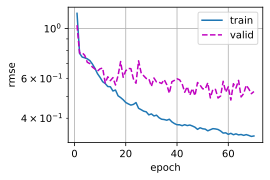

In [37]:
k, num_epochs, lr, weight_decay, batch_size =30,70,0.0001, 0,128 # 第一个是kfokd的值越高，训练集越多，第二个是代数，越高训练越多，前面三个都可以改，lr越少拟合程度会相对更好
train_l, valid_l, net= k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))
preds = net(test_features).asnumpy()
    # Reformat it for export to Kaggle
test_data['PresalesVolume'] = pd.Series(preds.reshape(1, -1)[0])
submission = pd.concat([test_data['adcode'],test_data['regYear'],test_data['regMonth'],test_data['province'],
                        test_data['model'] ,test_data['PresalesVolume'],test_data['salesVolume']], axis=1)
submission.to_csv('sales-0428-30-70-noassign.csv', index=False)

In [38]:
net

Sequential(
  (0): Dense(109 -> 128, Activation(sigmoid))
  (1): Dense(128 -> 128, Activation(sigmoid))
  (2): Dense(128 -> 1, linear)
)

In [39]:
newfile=pd.read_csv('sales-0428-30-70-noassign.csv')
newfile

,adcode,regYear,regMonth,province,model,PresalesVolume,salesVolume
0,410000,2016,3,河南,8cbac8dd8f0e89e2,203.955230,229
1,610000,2016,1,陕西,3c974920a76ac9c1,303.453640,298
2,450000,2016,2,广西,f5d69960089c3614,56.017155,18
3,320000,2016,8,江苏,b9aa8592ab2492da,394.382080,381
4,610000,2016,2,陕西,97f15de12cfabbd5,132.782640,89
...,...,...,...,...,...,...,...
8654,360000,2017,3,江西,ef76a85c4b39f693,135.981200,151
8655,510000,2017,12,四川,c6833cb891626c17,828.070900,1008
8656,420000,2017,12,湖北,9a390098bf87b814,56.640957,78
8657,530000,2017,12,云南,8527c11fccaa94e2,238.456220,265


In [40]:
newfile['PresalesVolume']-newfile['salesVolume']

0       -25.044770
1         5.453640
2        38.017155
3        13.382080
4        43.782640
           ...    
8654    -15.018800
8655   -179.929100
8656    -21.359043
8657    -26.543780
8658    -31.875230
Length: 8659, dtype: float64

In [41]:
newfile['difference']=newfile['PresalesVolume']-newfile['salesVolume']

In [42]:
number=list(int(x)for x in range(0,len(newfile)))

In [43]:
number=list(int(x)for x in range(0,len(newfile)))
newfile['loss']=1.0
for i in number:
    newfile['loss'][i]=(np.log(newfile['PresalesVolume'][i])-np.log(newfile['salesVolume'][i]))**2

C:\Users\34540\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [44]:
np.sqrt(sum(newfile['loss'])/len(newfile)) # New result loss 0.8% 

0.3397731500196431

In [45]:
newfile.to_csv('sales-0428-30-70-noassign-withloss.csv')

In [46]:
newfile['loss'].describe()

count    8.659000e+03
mean     1.154458e-01
std      5.376470e-01
min      4.894969e-11
25%      4.523248e-03
50%      2.076626e-02
75%      7.323109e-02
max      1.605250e+01
Name: loss, dtype: float64